Submission for an Deep learning based hackathon.

## Loading latest fastai

In [0]:
 !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


## Mounting Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/My Drive/'
base_dir = root_dir+ 'fast-ai/'

Mounted at /content/gdrive


## Implementation

In [0]:
from fastai.vision import *
from fastai.utils.mem import *

In [0]:
# workspace path
path = Path(base_dir+'data/gala')
path.ls()

[PosixPath('/content/gdrive/My Drive/fast-ai/data/gala/Train Images'),
 PosixPath('/content/gdrive/My Drive/fast-ai/data/gala/test.csv'),
 PosixPath('/content/gdrive/My Drive/fast-ai/data/gala/train.csv'),
 PosixPath('/content/gdrive/My Drive/fast-ai/data/gala/models'),
 PosixPath('/content/gdrive/My Drive/fast-ai/data/gala/Test Images'),
 PosixPath('/content/gdrive/My Drive/fast-ai/data/gala/export.pkl'),
 PosixPath('/content/gdrive/My Drive/fast-ai/data/gala/submission_28.csv')]

In [0]:
# quick glimse of dataset
df =  pd.read_csv(path/'train.csv')
df.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


In [0]:
gpu_mem_get_free_no_cache()

15068

In [0]:
np.random.seed(10) # fixing randomness (to get standard result everytime on training)

src = (ImageList.from_csv(path, 'train.csv', folder='Train Images')
      .split_by_rand_pct(.2)
      .label_from_df())

In [0]:
# handling transformations on data
data = (src.transform(get_transforms(), size=(98, 128))
       .databunch(bs=256).normalize(imagenet_stats))

In [0]:
data.classes, len(data.train_ds), len(data.valid_ds)

(['Attire', 'Decorationandsignage', 'Food', 'misc'], 4787, 1196)

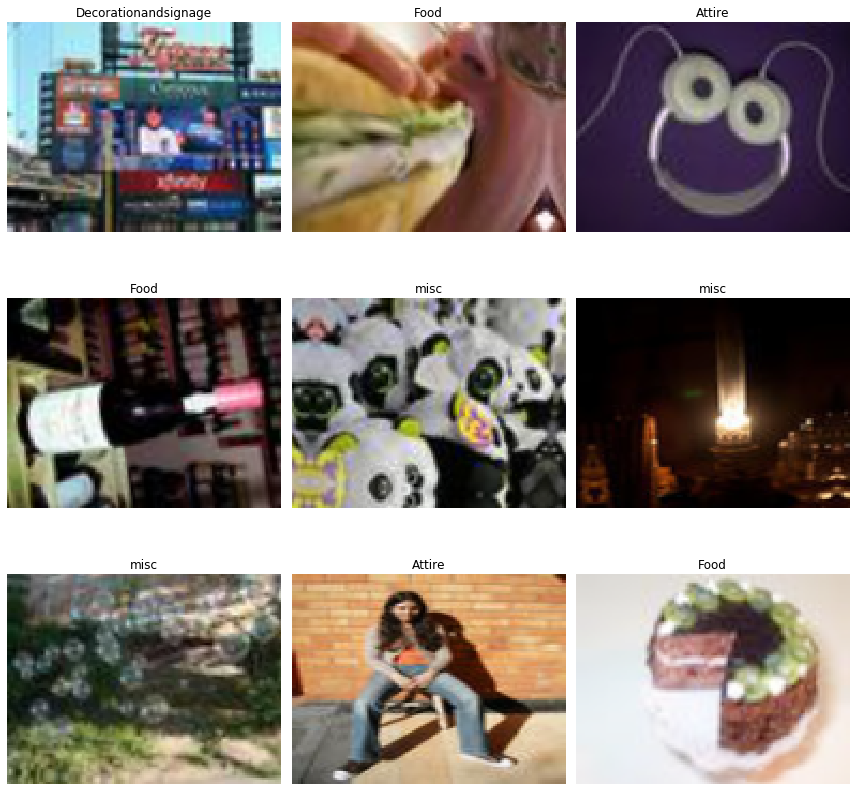

In [0]:
data.show_batch(3)

In [0]:
# defining classifier
learn = cnn_learner(data, models., metrics=accuracy,)

In [0]:
learn.model

In [0]:
learn.load('stage-2-128-rn152');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


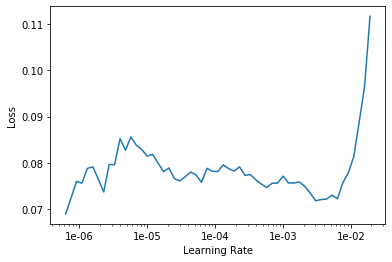

In [0]:
learn.recorder.plot()

In [0]:
lr = 3e-03

In [0]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.074912,0.049874,0.987458,00:30
1,0.068628,0.051230,0.984114,00:30
2,0.069236,0.074048,0.976589,00:29
3,0.070842,0.065908,0.979933,00:29
4,0.066071,0.086934,0.977425,00:29
5,0.058749,0.084747,0.978261,00:29
6,0.052642,0.089090,0.978261,00:29
7,0.047418,0.089542,0.977425,00:29
8,0.041692,0.090343,0.978261,00:30
9,0.037673,0.089910,0.977425,00:29


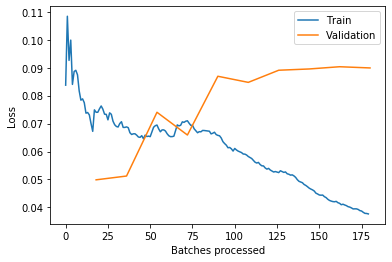

In [0]:
learn.recorder.plot_losses()

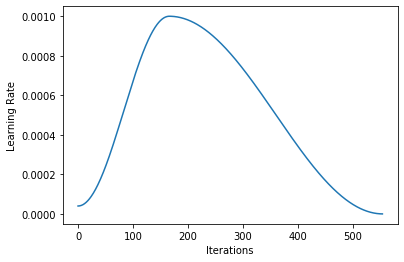

In [0]:
learn.recorder.plot_lr()

In [0]:
learn.save('stage-1-fn-rn152')

## Interpretation

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

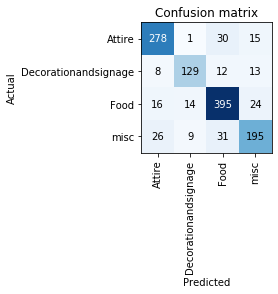

In [0]:
interp.plot_confusion_matrix()

## Fine tuning

In [0]:
learn.load('stage-1-fn-rn152');

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


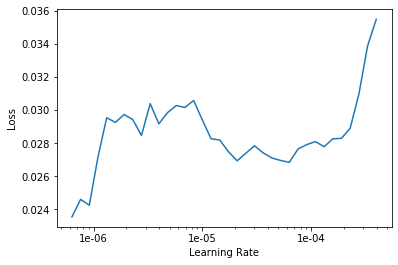

In [0]:
learn.recorder.plot()

In [0]:
new_lr = slice(1e-05, 1e-04)

In [0]:
learn.fit_one_cycle(10, new_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.025620,0.090547,0.976589,00:39
1,0.027334,0.094555,0.974916,00:38
2,0.028426,0.092461,0.978261,00:37
3,0.031172,0.100780,0.979097,00:37
4,0.030966,0.107055,0.975753,00:37
5,0.028536,0.104248,0.977425,00:37
6,0.025990,0.100370,0.974916,00:37
7,0.022420,0.100557,0.976589,00:37
8,0.021509,0.101384,0.977425,00:37
9,0.020801,0.101050,0.978261,00:37


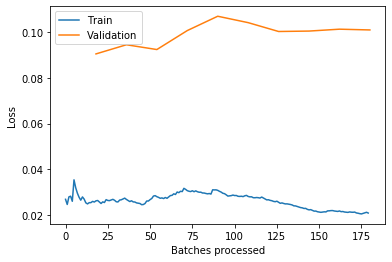

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-fn-rn152')
# learn.load('stage-2-114-rn152')

In [0]:
learn.export()

## Inference

In [0]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fast-ai/data/gala/Train Images'),
 PosixPath('/content/gdrive/My Drive/fast-ai/data/gala/test.csv'),
 PosixPath('/content/gdrive/My Drive/fast-ai/data/gala/train.csv'),
 PosixPath('/content/gdrive/My Drive/fast-ai/data/gala/models'),
 PosixPath('/content/gdrive/My Drive/fast-ai/data/gala/Test Images'),
 PosixPath('/content/gdrive/My Drive/fast-ai/data/gala/export.pkl'),
 PosixPath('/content/gdrive/My Drive/fast-ai/data/gala/submission_28.csv')]

In [0]:
test_ds = ImageList.from_csv(path, 'test.csv', folder='Test Images')

In [0]:
# creating new classifier to add test data
learn = load_learner(path, test=test_ds)

In [0]:
# prediction on testset
pred, y = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
pred[:3]

tensor([[8.6416e-08, 4.7566e-07, 9.9998e-01, 1.5331e-05],
        [3.8188e-03, 9.6370e-04, 9.8925e-01, 5.9706e-03],
        [1.2725e-06, 2.1977e-05, 9.9997e-01, 6.4487e-06]])

In [0]:
# acquiring labels
pred_label = [learn.data.classes[np.argmax(p)] for p in pred]

In [0]:
pred_label[:3]

['Food', 'Food', 'Food']

In [0]:
# acquiring filenames
fnames = [f.split('/')[-1] for f in learn.data.test_ds.items]

In [0]:
fnames[:3]

['image6245.jpg', 'image10409.jpg', 'image8692.jpg']

In [0]:
# creating new csv using pandas DF
df = pd.DataFrame({'Image':fnames, 'Class':pred_label}, columns=['Image', 'Class'])

In [0]:
df.to_csv(path/'submission_28.csv', index=False)

In [0]:
df2 = pd.read_csv(path/'submission_28.csv')
df2.head()

,Image,Class
0,image6245.jpg,Food
1,image10409.jpg,Food
2,image8692.jpg,Food
3,image10517.jpg,Food
4,image2580.jpg,Attire
